### Bibliotheken importieren

In [699]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, RFE

In [700]:
plt.style.use('dark_background')

## 1. Datenexploration

### Daten laden

In [701]:
df = pd.read_csv('./data/windmill_data.csv')

print("Allgemeine Informationen:")
print(df.info())

Allgemeine Informationen:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53093 entries, 0 to 53092
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   turbine_id              53093 non-null  object 
 1   timestamp               53093 non-null  object 
 2   turbine_type            53093 non-null  object 
 3   maintenance_team        53093 non-null  object 
 4   wind_speed_ms           53093 non-null  float64
 5   wind_direction          53093 non-null  object 
 6   power_output_kw         53093 non-null  float64
 7   vibration_mm_s          52032 non-null  float64
 8   temperature_c           52563 non-null  float64
 9   hydraulic_pressure_bar  53093 non-null  float64
 10  days_since_maintenance  53093 non-null  int64  
 11  failure_risk_30d        53093 non-null  int64  
dtypes: float64(5), int64(2), object(5)
memory usage: 4.9+ MB
None


In [702]:
print("Die verfügbaren Spalten:")
print(df.columns)

Die verfügbaren Spalten:
Index(['turbine_id', 'timestamp', 'turbine_type', 'maintenance_team',
       'wind_speed_ms', 'wind_direction', 'power_output_kw', 'vibration_mm_s',
       'temperature_c', 'hydraulic_pressure_bar', 'days_since_maintenance',
       'failure_risk_30d'],
      dtype='object')


In [703]:
print("Die ersten Zeilen des Datensatzes:")
print(df.head())

Die ersten Zeilen des Datensatzes:
  turbine_id            timestamp turbine_type maintenance_team  \
0       T001  2022-01-01 00:00:00   Vestas V90           Team_B   
1       T001  2022-01-01 04:00:00   Vestas V90           Team_B   
2       T001  2022-01-01 08:00:00   Vestas V90           Team_B   
3       T001  2022-01-01 12:00:00   Vestas V90           Team_B   
4       T001  2022-01-01 16:00:00   Vestas V90           Team_B   

   wind_speed_ms wind_direction  power_output_kw  vibration_mm_s  \
0          11.45             SE           1562.2           0.750   
1          15.11              W           1800.0           0.774   
2          14.30             SW           1800.0           0.885   
3          15.55              W           1800.0           0.005   
4          10.88              W           1340.6           1.248   

   temperature_c  hydraulic_pressure_bar  days_since_maintenance  \
0           58.0                   182.3                     106   
1           63.4 

In [704]:
print("Statistische Zusammenfassung:")
print(df.describe())

Statistische Zusammenfassung:
       wind_speed_ms  power_output_kw  vibration_mm_s  temperature_c  \
count   53093.000000     53093.000000    52032.000000   52563.000000   
mean       10.624950      1690.621101        1.529983      73.448443   
std         3.442334      1534.366938        0.928547      12.513317   
min         0.000000         0.000000        0.000000      31.700000   
25%         8.250000       661.600000        0.920000      64.600000   
50%        10.630000      1479.700000        1.416000      72.200000   
75%        12.980000      1800.000000        1.984000      81.000000   
max        57.830000      6000.000000        8.823000     130.500000   

       hydraulic_pressure_bar  days_since_maintenance  failure_risk_30d  
count            53093.000000            53093.000000      53093.000000  
mean               169.225329               33.631232          0.009794  
std                 11.514948               23.185967          0.098480  
min                133.10

In [705]:
print("Anzahl fehlender Werte:")
print(df.isnull().sum())

print("\nAnzahl fehlender Werte insgesamt:")
print(df.isnull().sum().sum())

Anzahl fehlender Werte:
turbine_id                   0
timestamp                    0
turbine_type                 0
maintenance_team             0
wind_speed_ms                0
wind_direction               0
power_output_kw              0
vibration_mm_s            1061
temperature_c              530
hydraulic_pressure_bar       0
days_since_maintenance       0
failure_risk_30d             0
dtype: int64

Anzahl fehlender Werte insgesamt:
1591


In [706]:
for col in df.columns:
    print(f"Werte für \033[93m'{col}'\033[0m:")
    print(df[col].value_counts())

Werte für 'turbine_id':
turbine_id
T004    2139
T007    2135
T020    2135
T023    2133
T013    2132
T021    2131
T019    2129
T015    2129
T012    2128
T001    2127
T009    2127
T005    2125
T016    2123
T008    2122
T006    2121
T010    2120
T018    2119
T017    2119
T003    2117
T022    2117
T025    2116
T011    2115
T002    2114
T014    2113
T024    2107
Name: count, dtype: int64
Werte für 'timestamp':
timestamp
2022-01-07 20:00:00    20
2022-01-08 16:00:00    20
2022-11-24 00:00:00    20
2022-01-05 12:00:00    20
2022-01-04 00:00:00    20
                       ..
2022-08-04 06:00:00     3
2022-09-12 10:00:00     3
2022-11-23 10:00:00     3
2022-01-06 06:00:00     3
2022-07-13 06:00:00     3
Name: count, Length: 4380, dtype: int64
Werte für 'turbine_type':
turbine_type
GE 1.5MW         17006
Vestas V90       14857
Siemens SWT      10626
Enercon E-126    10604
Name: count, dtype: int64
Werte für 'maintenance_team':
maintenance_team
Team_B    19132
Team_D    16992
Team_A     8488
Tea

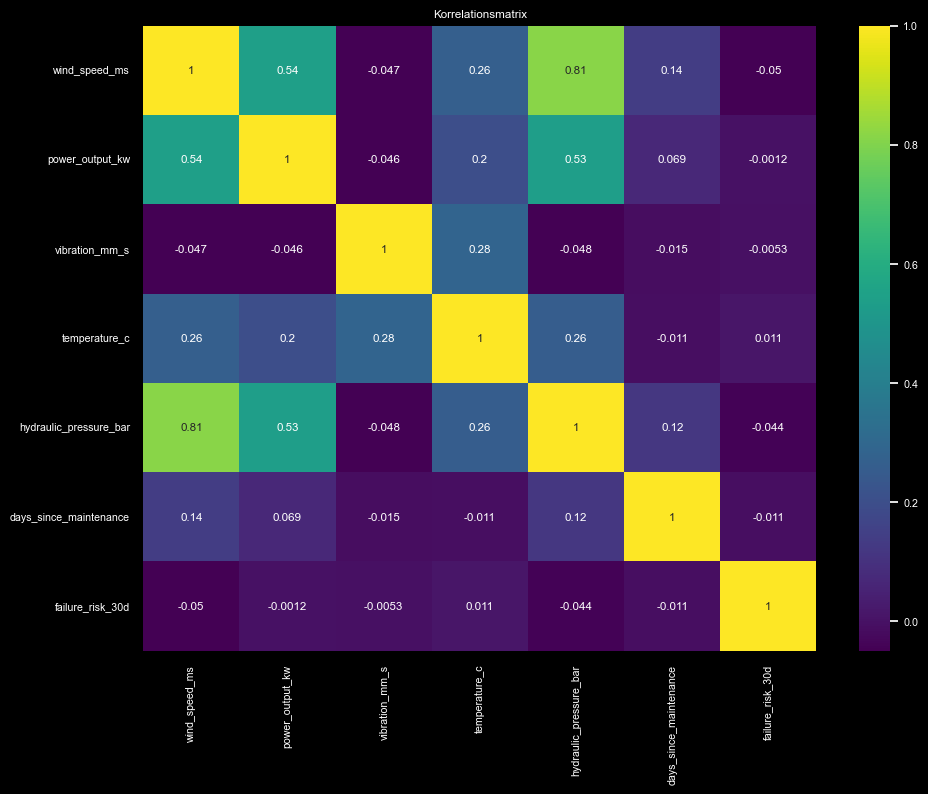

In [707]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="viridis")
plt.title("Korrelationsmatrix")
plt.tight_layout()
plt.show()

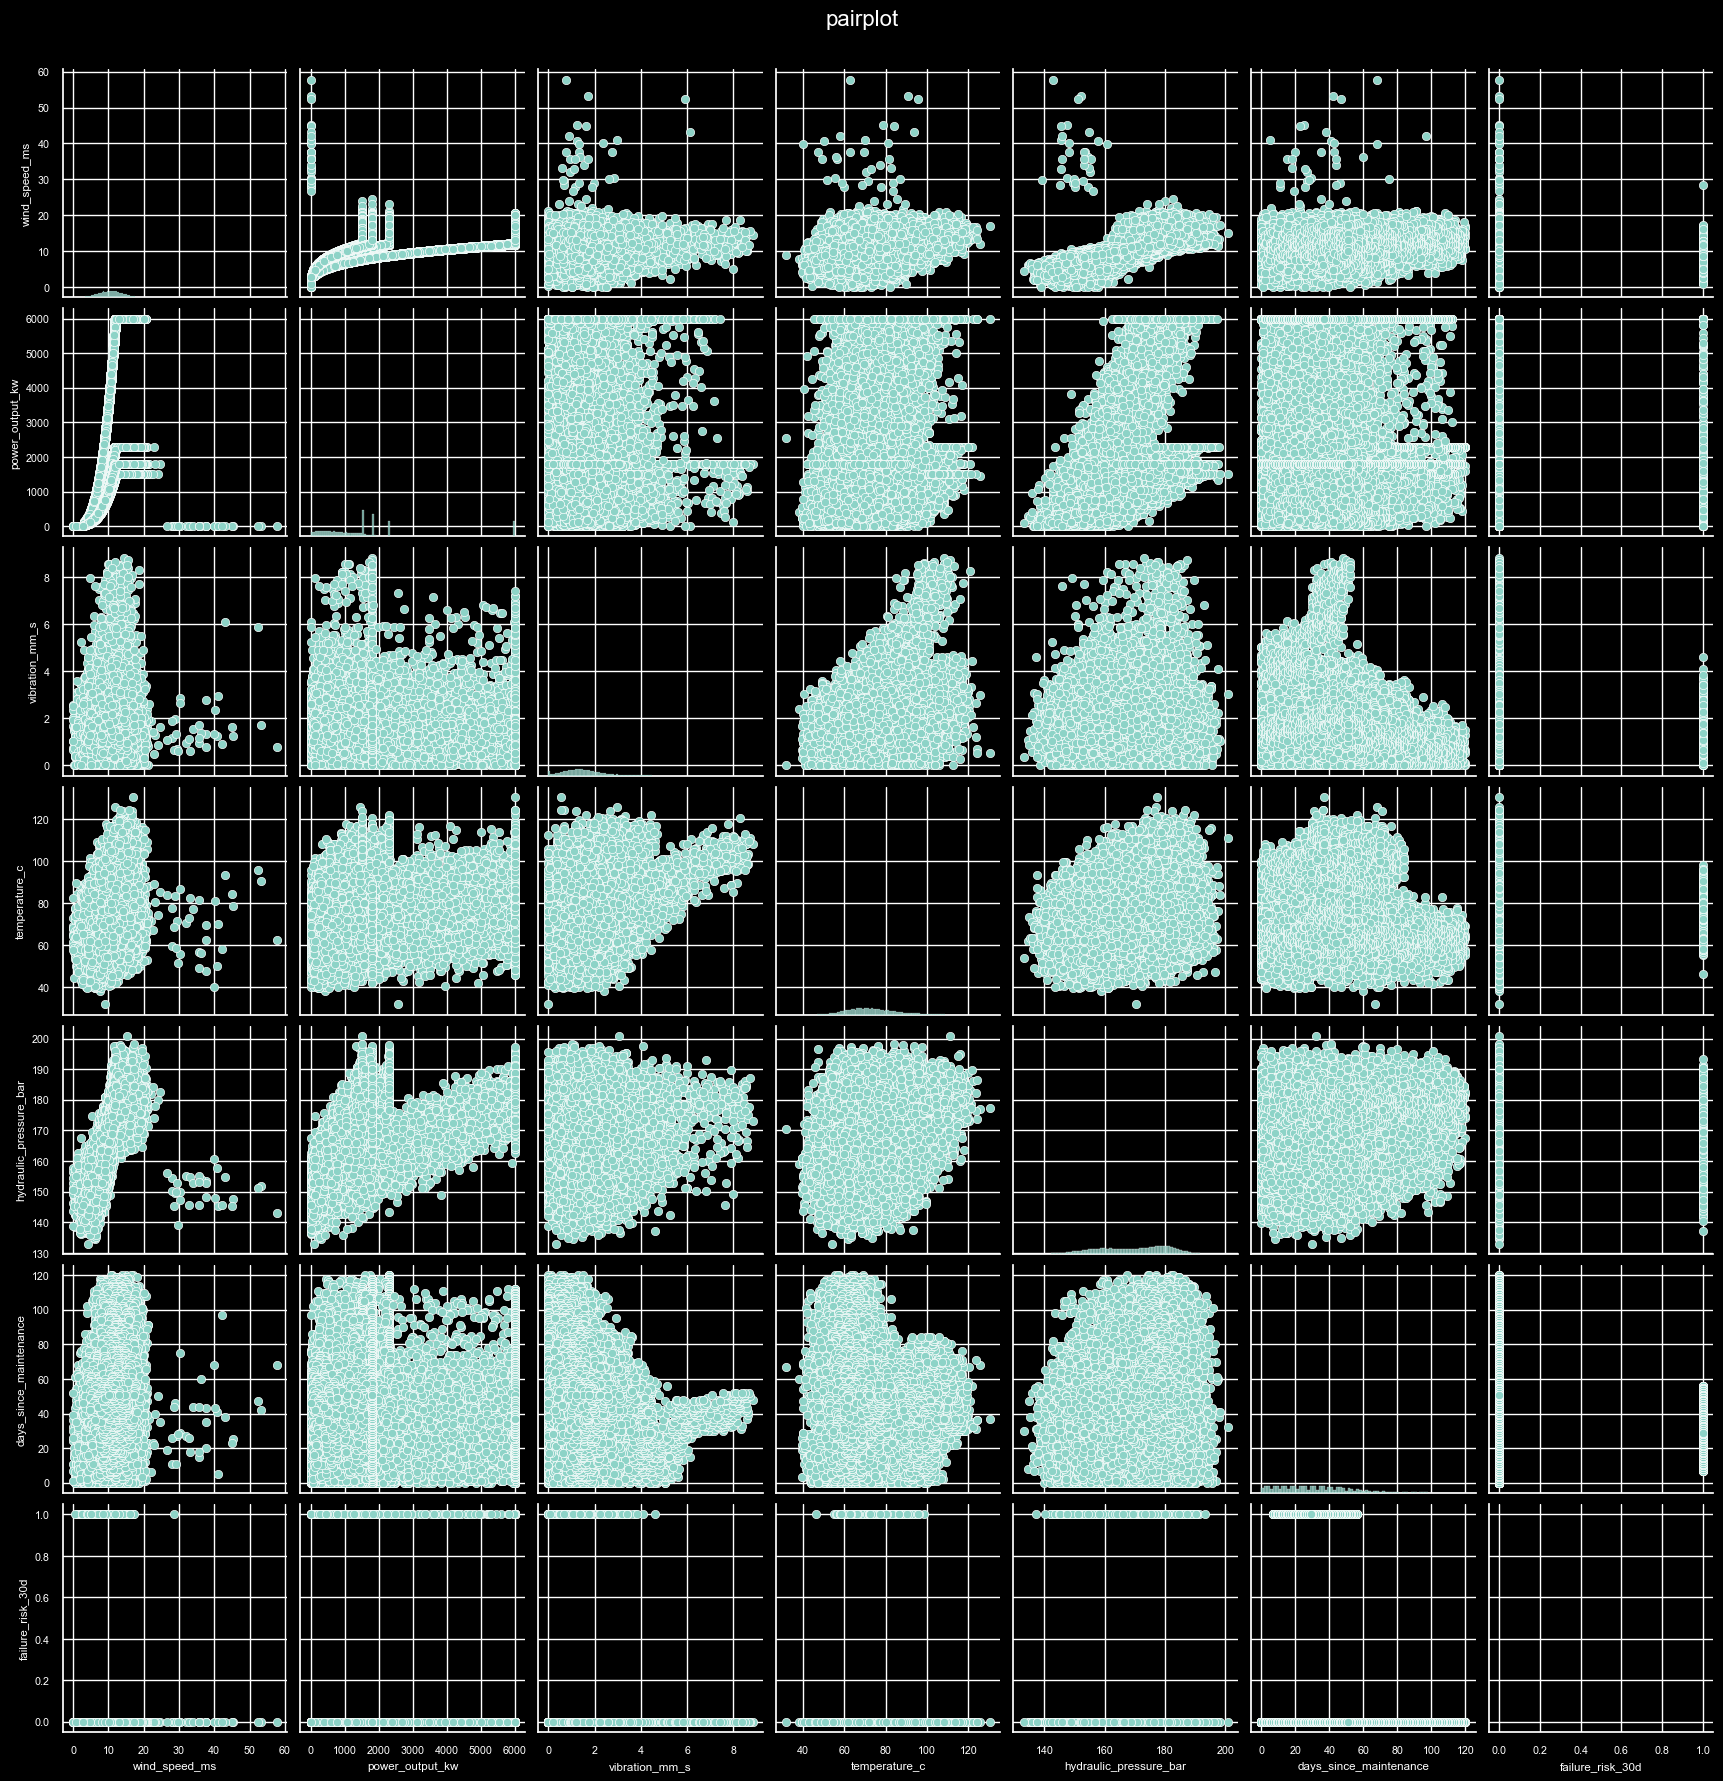

In [708]:
numerical_cols = ['wind_speed_ms', 'power_output_kw', 'vibration_mm_s', 'temperature_c', 'hydraulic_pressure_bar', 'days_since_maintenance', 'failure_risk_30d']

sns.pairplot(df[numerical_cols])
plt.suptitle("pairplot", y=1.02, fontsize=16)
plt.show()

hier ist es sinnvoll nach "failure_risk_30d" zu klassifizieren, da man so anhand der anderen Daten einschätzen kann, ob es einen Ausfall gibt. In den Daten gibt es entweder 0 oder 1. Daraus folgt, dass zwischen 0 und 1 klassifiziert werden sollte. "temperature_c" und "vibration_mm_s" haben fehlende Werte, die beachtet werden sollten.

(Zusätzlich wurde zur Analyse der Daten die VSCode-Erweiterung Data-Wrangler verwendet)

In [709]:
failure_df = df[df['failure_risk_30d'] == 1]

machines_with_failure = failure_df['turbine_id'].unique()
print("Maschinen mit Ausfall:", machines_with_failure)

Maschinen mit Ausfall: ['T004' 'T006' 'T020']


## 2. Datenaufbereitung

### Feature-Transformationen

In [710]:
# 1
# stärkere Gewichtung von hoher Windgeschwindigkeit
df["ft_wind_speed_ms_squared"] = df["wind_speed_ms"] ** 2

# 2
# stärkere Gewichtung von extremen Temperaturen, hoch 3, da negativ
mean_temp = df["temperature_c"].mean()
df["ft_temperature_c_extreme"] = (df["temperature_c"] - mean_temp) ** 3

# (2.5)
df["timestamp"] = pd.to_datetime(df["timestamp"])
def get_season(dt):
    month = dt.month
    if month in [1, 2, 12]:
        return "winter"
    elif month in [3, 4, 5]:
        return "spring"
    elif month in [6, 7, 8]:
        return "summer"
    else:
        return "autumn"

# 3
df["ft_season"] = df["timestamp"].apply(get_season)

### Interaktionsfeatures

In [711]:
# 1 Zusammenhang zwischen Temperatur und Druck -> Außreißer könnten auf Überhitzung hindeuten
df["if_temp_pressure"] = df["temperature_c"] / df["hydraulic_pressure_bar"].replace(0, 1e-6) 

# 2 Zusammenhang ziwschen Windgeschwindigkeit und Leistung -> wenn werte größer werden, dann ist das Leistungslimit erreicht
df["if_wind_speed_power"] = df["wind_speed_ms"] / df["power_output_kw"].replace(0, 1e-6) 

# 3 hohe Auslastung der Turbine durch hohe Vibration und Windgeschwindigkeit -> Sturm
df["if_speed_vibration"] = df["wind_speed_ms"] * df["vibration_mm_s"]

# 4 wenn temperatur hoch ist und durch den wind sich die turbione erhitzt -> höhere Belastung, hohe Windgeschwindigkeit im Sommer
df["if_speed_temp"] = df["wind_speed_ms"] * df["temperature_c"]

# 5 wenn die Turbine viel Strom produziert, dann ist sie heißer
df["if_overheating"] = df["power_output_kw"] * df["temperature_c"]

# 6 wenig Strom aber trotzdem vibration -> mglw. lockere Komponenten
df["if_unusual_vibration"] = df["power_output_kw"] * df["vibration_mm_s"]

# 7 Strom der pro Windgeschwindigkeit erzeugt wird
df["if_power_per_wind"] = df["power_output_kw"] / df["wind_speed_ms"].replace(0, 1e-6) 

# 8 allgemein hohe Auslastung
df["if_high_pressure"] =  df["hydraulic_pressure_bar"] * df["wind_speed_ms"] * df["vibration_mm_s"]

### Zeibasierte Features

In [712]:
# 1 Temperaturdifferenz -> schnell hohe Wechsel deutet auf besondere Wetterbedingungen hin
df["tf_temperature_difference"] = df["temperature_c"].diff().fillna(0)

# 2 Durchschnitt eines Tages, da Werte jeweils 4h auseinender liegen
df['tf_wind_speed_mean'] = df['wind_speed_ms'].rolling(window=6).mean().fillna(0)

# 3 Monat
df['month'] = df['timestamp'].dt.month

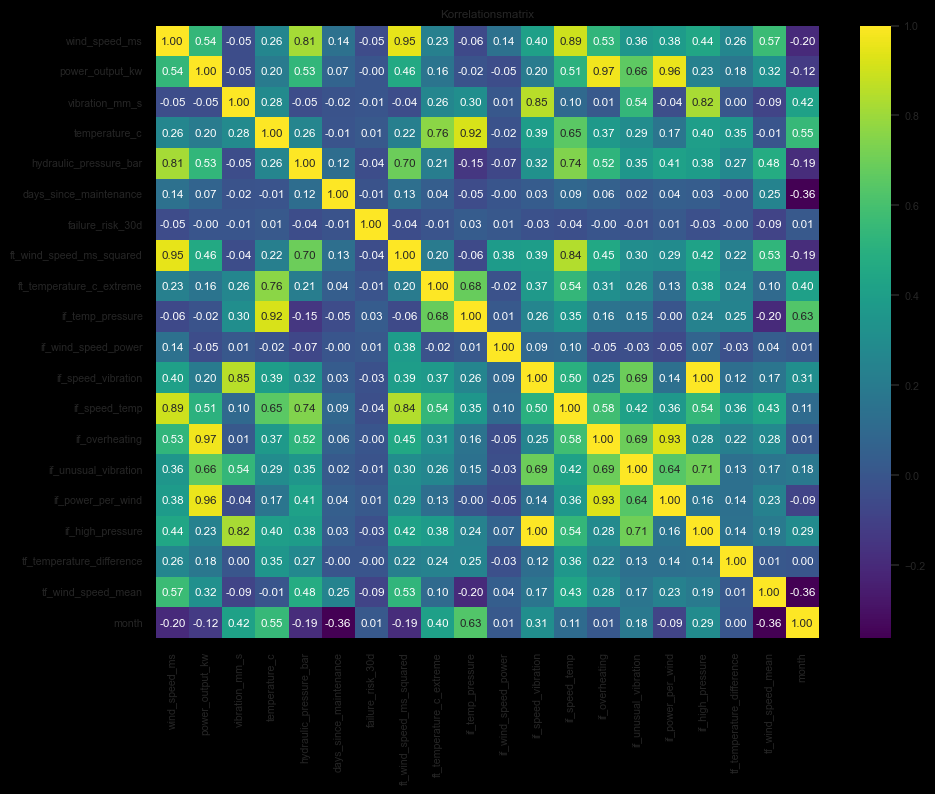

In [713]:
plt.figure(figsize=(10, 8))
sns.set(font_scale=0.7)
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="viridis")
plt.title("Korrelationsmatrix")
plt.tight_layout()
plt.show()

### Durchführung notwendiger Transformationen

In [714]:
# für temporal splitting
df = df.sort_values("timestamp")

# unnötige Spalten entfernen, maintenance-Features entfernen
X = df.drop(['failure_risk_30d', 'days_since_maintenance', 'maintenance_team', 'timestamp'], axis=1)
# Zielvariable definieren
y = df['failure_risk_30d']

X.info()
# Löschen fehlender Werte
X = X.dropna(subset=['vibration_mm_s', 'temperature_c'])
X.info()

# Sicherstellen dass y die gleiche Länge wie x hat
y = y.loc[X.index]

<class 'pandas.core.frame.DataFrame'>
Index: 53093 entries, 0 to 53092
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   turbine_id                 53093 non-null  object 
 1   turbine_type               53093 non-null  object 
 2   wind_speed_ms              53093 non-null  float64
 3   wind_direction             53093 non-null  object 
 4   power_output_kw            53093 non-null  float64
 5   vibration_mm_s             52032 non-null  float64
 6   temperature_c              52563 non-null  float64
 7   hydraulic_pressure_bar     53093 non-null  float64
 8   ft_wind_speed_ms_squared   53093 non-null  float64
 9   ft_temperature_c_extreme   52563 non-null  float64
 10  ft_season                  53093 non-null  object 
 11  if_temp_pressure           52563 non-null  float64
 12  if_wind_speed_power        53093 non-null  float64
 13  if_speed_vibration         52032 non-null  float64


### Aufteilung von Trainings- und Testdaten und verwenden eines Random-States
##### hier Split-Technik einstellen (ich benutze random, weil das die besten Werte liefert)

In [715]:
split_technique = 'random'  # 'temporal', 'old_new', 'random'

##### alter Split

In [716]:

if split_technique == 'random':
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

##### temporaler Split

In [717]:
if split_technique == 'temporal':
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['jahr_monat'] = df['timestamp'].dt.to_period('M')

    # time based splitting, September hat die beste Aufteilung
    split_month = '2022-9'

    train_mask = df.loc[X.index, 'jahr_monat'] < split_month
    test_mask = df.loc[X.index, 'jahr_monat'] >= split_month

    X_train = X[train_mask]
    X_test = X[test_mask]

    y_train = y[train_mask]
    print("Werteaufteilung \033[93mTrainingsdaten\033[0m:", y_train.value_counts())
    y_test = y[test_mask]
    print("Werteaufteilung \033[93mTestdaten\033[0m:", y_test.value_counts())

##### Split nach "alten" und "neuen" Turbinen

In [718]:
if split_technique == 'old_new':
    split_id = "T014"
    X_train = X[X["turbine_id"] <= split_id].drop(columns=["turbine_id"])
    X_test = X[X["turbine_id"] > split_id].drop(columns=["turbine_id"])
    #! da hier X überschrieben wird, muss man die oberen Zellen auch nochmal ausführen
    X = X.drop(columns=["turbine_id"])
    y_train = y.loc[X_train.index]
    y_test = y.loc[X_test.index]
    print(y_train.value_counts())
    print(y_test.value_counts())

das Aufteilen der Turbinen anhand alt und neu (in diesem Fall die IDs der Turbinen) erzeugt so dermaßen schlechte Ergebnisse, dass außer beim Gradient Boosting und Extreme Gradient Boosting mit custom Threshold (0.1) Recall, Precision und F1-Score überall 0 sind. Der berechnete Recall liegt hierbei nur bei 6% bzw. bei 1%. (Zusätzlich habe ich noch probiert bei T019 zu splitten, da war alles 0). In der unteren Abbildung zur Feature Importance konnte erkannt werden, dass Turbine 4, 6 und 20 am ausschlaggebensten sind, wehalb der Split irgendwo hierzwischen passieren muss. Für weitere Experimente reich die vorgegebene Zeit nicht aus 

### Encoding (+Interpretation der imbalanced data Strategien)

In [719]:
# encoding (temporaler split muss manuell ausgeführt werden, bevor diese Zelle ausgeführt wird)
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ]
)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# troubleshooting (GPT generated)
# nans_per_col = np.isnan(X_train_processed).sum(axis=0)
# print("NaNs per column:", nans_per_col)
# cols_with_nans = np.where(nans_per_col > 0)[0]
# print("Columns with NaNs (indices):", cols_with_nans)
# feature_names = preprocessor.get_feature_names_out()
# for idx in cols_with_nans:
#     print(f"Column {idx}: {feature_names[idx]}")


# UNDERSAMPLING für schnelleres Training und bessere Verteilung
#rus = RandomUnderSampler(random_state=42)
#X_train_processed, y_train = rus.fit_resample(X_train_processed, y_train)
# -> da das Undersampling so lange Werte löscht, bis die Anzahl beider Klassen gleich ist,
# bleiben hier nur noch 800 Einträge übrig, zu wenig -> lieber SMOTE um Einträge aufzufüllen


# gleichmäßige Aufteilung der Klassen (OVERSAMPLING)
smote = SMOTE(random_state=42)
X_train_processed, y_train = smote.fit_resample(X_train_processed, y_train)
print(y_train.value_counts()) # -> gleich viele Einträge der Klassen 1 und 0
# Ergebnisse sond trotzdem nicht viel besser, da der Ausgangsdatensatz klein ist und wenig unterschiedliche Daten vorweist

# sonst wird thresholding zum umgang mit unbalancierten Daten verwendet
# im Training wird class_weight='balanced' verwendet, um auch hier eine Balance zu schaffen

failure_risk_30d
0    40806
1    40806
Name: count, dtype: int64


### Feature Selection

In [720]:
feature_selection = False

In [721]:
if feature_selection:
    feature_names = preprocessor.get_feature_names_out()
    selector = SelectKBest(score_func=f_classif, k=5) # bei k=10 deutlich schlechtere Ergebnisse
    X_train_processed = selector.fit_transform(X_train_processed, y_train)
    X_test_processed = selector.transform(X_test_processed)
    
    selected_mask = selector.get_support()
    selected_features = feature_names[selected_mask]
    print(selected_features)

## 3. Modelltraining

In [ ]:
def threshold_tuning(model, X_test_processed, y_test):
    y_proba = model.predict_proba(X_test_processed)[:, 1]
    thresholds = np.arange(0.1, 0.91, 0.01)
    best_score = -1
    best_threshold = None
    y_pred_lr_ct = None

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)
        score = recall_score(y_test, y_pred) # kann auch durch f1_score ersetzt werden
        if score > best_score:
            best_score = score
            best_threshold = t
            y_pred_lr_ct = y_pred 

    return best_threshold, y_pred_lr_ct, best_score

### Logistische Regression

In [723]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_processed, y_train)
y_pred_lr = lr.predict(X_test_processed)

best_threshold_lr, y_pred_lr_ct, best_score = threshold_tuning(lr, X_test_processed, y_test)
print(f"Bester Threshold: {best_threshold_lr:.2f} mit Score: {best_score:.3f}")

Bester Threshold: 0.10 mit Score: 1.000


### Logistische Regression (Embedded)

In [724]:
lr_1 = LogisticRegression(penalty="l1", solver="liblinear", max_iter=1000, random_state=42 , class_weight='balanced')
lr_1.fit(X_train_processed, y_train)
y_pred_lr_1 = lr_1.predict(X_test_processed)

embedded_mask = lr_1.coef_[0] != 0
embedded_features = feature_names[embedded_mask]
print("Embedded Features:", embedded_features)

best_threshold_lr_1, y_pred_lr_1_ct, best_score = threshold_tuning(lr_1, X_test_processed, y_test)
print(f"Bester Threshold: {best_threshold_lr_1:.2f} mit Score: {best_score:.3f}")

Embedded Features: ['num__wind_speed_ms' 'num__power_output_kw' 'num__vibration_mm_s'
 'num__temperature_c' 'num__hydraulic_pressure_bar'
 'num__ft_wind_speed_ms_squared' 'num__ft_temperature_c_extreme'
 'num__if_temp_pressure' 'num__if_wind_speed_power'
 'num__if_speed_vibration' 'num__if_speed_temp' 'num__if_overheating'
 'num__if_unusual_vibration' 'num__if_power_per_wind'
 'num__if_high_pressure' 'num__tf_temperature_difference'
 'num__tf_wind_speed_mean' 'cat__turbine_id_T004' 'cat__turbine_id_T006'
 'cat__turbine_id_T008' 'cat__turbine_id_T013' 'cat__turbine_id_T020'
 'cat__turbine_id_T024' 'cat__turbine_type_Enercon E-126'
 'cat__turbine_type_GE 1.5MW' 'cat__turbine_type_Siemens SWT'
 'cat__turbine_type_Vestas V90' 'cat__wind_direction_E'
 'cat__wind_direction_N' 'cat__wind_direction_NE' 'cat__wind_direction_S'
 'cat__wind_direction_SE' 'cat__wind_direction_SW' 'cat__wind_direction_W'
 'cat__ft_season_autumn' 'cat__ft_season_spring' 'cat__ft_season_summer'
 'cat__ft_season_winte

### Decision Tree

In [725]:
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train_processed, y_train)
y_pred_dt = dt.predict(X_test_processed)

best_threshold_dt, y_pred_dt_ct, best_score = threshold_tuning(dt, X_test_processed, y_test)
print(f"Bester Threshold: {best_threshold_dt:.2f} mit Score: {best_score:.3f}")

Bester Threshold: 0.10 mit Score: 0.446


### KNN

In [726]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn.fit(X_train_processed, y_train)
y_pred_knn = knn.predict(X_test_processed)

best_threshold_knn, y_pred_knn_ct, best_score = threshold_tuning(knn, X_test_processed, y_test)
print(f"Bester Threshold: {best_threshold_knn:.2f} mit Score: {best_score:.3f}")

Bester Threshold: 0.10 mit Score: 0.901


### Random Forest

In [727]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_processed, y_train)
y_pred_rf = rf.predict(X_test_processed)

best_threshold_rf, y_pred_rf_ct, best_score = threshold_tuning(rf, X_test_processed, y_test)
print(f"Bester Threshold: {best_threshold_rf:.2f} mit Score: {best_score:.3f}")

Bester Threshold: 0.10 mit Score: 0.960


### Bagging

In [728]:
bagging = BaggingClassifier(estimator=dt, random_state=42)
bagging.fit(X_train_processed, y_train)
y_pred_bag = bagging.predict(X_test_processed)

best_threshold_bag, y_pred_bag_ct, best_score = threshold_tuning(bagging, X_test_processed, y_test)
print(f"Bester Threshold: {best_threshold_bag:.2f} mit Score: {best_score:.3f}")

Bester Threshold: 0.10 mit Score: 0.881


### Gradient Boosting

In [729]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_processed, y_train)
y_pred_gb = gb.predict(X_test_processed)

best_threshold_gb, y_pred_gb_ct, best_score = threshold_tuning(gb, X_test_processed, y_test)
print(f"Bester Threshold: {best_threshold_gb:.2f} mit Score: {best_score:.3f}")

Bester Threshold: 0.10 mit Score: 1.000


### XGBoost

In [730]:
xgb = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
xgb.fit(X_train_processed, y_train)
y_pred_xgb = xgb.predict(X_test_processed)

best_threshold_xgb, y_pred_xgb_ct, best_score = threshold_tuning(xgb, X_test_processed, y_test)
print(f"Bester Threshold: {best_threshold_xgb:.2f} mit Score: {best_score:.3f}")

Bester Threshold: 0.10 mit Score: 0.911


### XGBoost (mit feature selection (wrapper))

In [ ]:
feature_names = preprocessor.get_feature_names_out()
xgb_1 = XGBClassifier(random_state=42, eval_metric='logloss', scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
wrapper_selector = RFE(estimator=xgb_1, n_features_to_select=5)

X_train_selected = wrapper_selector.fit_transform(X_train_processed, y_train)
X_test_selected = wrapper_selector.transform(X_test_processed)

wrapper_mask = wrapper_selector.get_support()
wrapper_features = feature_names[wrapper_mask]
print("Wrapper (RFE) ausgewählte Features:", wrapper_features)

xgb_1.fit(X_train_selected, y_train)
y_pred_xgb_1 = xgb_1.predict(X_test_selected)

best_threshold_xgb_1, y_pred_xgb_1_ct, best_score = threshold_tuning(xgb_1, X_test_selected, y_test)
print(f"Bester Threshold: {best_threshold_xgb_1:.2f} mit Score: {best_score:.3f}")

Wrapper (RFE) ausgewählte Features: ['cat__turbine_id_T004' 'cat__turbine_id_T006' 'cat__turbine_id_T020'
 'cat__turbine_type_GE 1.5MW' 'cat__ft_season_summer']
Bester Threshold: 0.10 mit Score: 1.000


### 3.1 Cross-Validation (nicht beachten)

In [732]:
use_crossvalidation = False

##### 1. KNN

In [733]:
if use_crossvalidation:
    # GridSearchCV für KNN
    print("\nOptimierung des KNN-Modells mit GridSearchCV:")
    param_grid = {
        'n_neighbors': range(1, 21),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    }
    
    grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
    grid_knn.fit(X_train_processed, y_train)
    
    print(f"Beste Parameter: {grid_knn.best_params_}")
    print(f"Beste Kreuzvalidierungs-Genauigkeit: {grid_knn.best_score_:.4f}")


##### Decision Tree

In [734]:
if use_crossvalidation:
    # GridSearchCV für Entscheidungsbaum
    print("\nOptimierung des Entscheidungsbaum-Modells mit GridSearchCV:")
    param_grid = {
        'max_depth': range(1, 20),
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
    }
    
    grid_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5)
    grid_dt.fit(X_train_processed, y_train)
    
    print(f"Beste Parameter: {grid_dt.best_params_}")
    print(f"Beste Kreuzvalidierungs-Genauigkeit: {grid_dt.best_score_:.4f}")


In [735]:
if use_crossvalidation:
    # Vergleich der finalen Modelle
    best_knn = grid_knn.best_estimator_
    best_dt = grid_dt.best_estimator_
    
    y_pred_best_knn = best_knn.predict(X_test_processed)
    y_pred_best_dt = best_dt.predict(X_test_processed)
    
    print("\nFinaler Modellvergleich:")
    print(f"KNN Genauigkeit: {accuracy_score(y_test, y_pred_best_knn):.4f}")
    print(f"Entscheidungsbaum Genauigkeit: {accuracy_score(y_test, y_pred_best_dt):.4f}")
    
    # Konfusionsmatrizen der finalen Modelle
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # KNN Konfusionsmatrix
    
    sns.heatmap(confusion_matrix(y_test, y_pred_best_knn), annot=True, fmt='d', cmap='Blues')
    ax1.set_xlabel('Vorhergesagte Klasse')
    ax1.set_ylabel('Tatsächliche Klasse')
    ax1.set_title('Konfusionsmatrix für optimiertes KNN')
    
    # Entscheidungsbaum Konfusionsmatrix
    sns.heatmap(confusion_matrix(y_test, y_pred_best_dt), annot=True, fmt='d', cmap='Blues')
    ax2.set_xlabel('Vorhergesagte Klasse')
    ax2.set_ylabel('Tatsächliche Klasse')
    ax2.set_title('Konfusionsmatrix für optimierten Entscheidungsbaum')
    
    plt.tight_layout()
    plt.show()
    


## 4. Modellbewertung

### Klassifikationsbericht

hier sollte insbesondere auf den Precision, Recall und F1-Score der Klasse **1** geachtet werden

In [736]:
def print_classification_report(y_pred, title):
    print(f"\033[92m{title}\033[0m Modellbewertung:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("\nKlassifikationsbericht:")
    print(classification_report(y_test, y_pred, zero_division=0))

# übersichtliche Tabelle der Ergebnisse
print_classification_report(y_pred_lr, "Logistische Regression")
print_classification_report(y_pred_lr_ct, f"Logistische Regression custom threshold {best_threshold_lr}")
print_classification_report(y_pred_lr_1, "Logistische Regression with Embedded")
print_classification_report(y_pred_lr_1_ct, f"Logistische Regression with Embedded custom threshold {best_threshold_lr}")
print_classification_report(y_pred_dt, "Decision Tree")
print_classification_report(y_pred_dt_ct, f"Decision Tree custom threshold {best_threshold_dt}")
print_classification_report(y_pred_knn, "KNN")
print_classification_report(y_pred_knn_ct, f"KNN custom threshold {best_threshold_knn}")
print_classification_report(y_pred_rf, "Random Forest")
print_classification_report(y_pred_rf_ct, f"Random Forest custom threshold {best_threshold_rf}")
print_classification_report(y_pred_bag, "Bagging")
print_classification_report(y_pred_bag_ct, f"Bagging custom threshold {best_threshold_bag}")
print_classification_report(y_pred_gb, "Gradient Boosting")
print_classification_report(y_pred_gb_ct, f"Gradient Boosting custom threshold {best_threshold_gb}")
print_classification_report(y_pred_xgb, "Extreme Gradient Boosting")
print_classification_report(y_pred_xgb_ct, f"Extreme Gradient Boosting custom threshold {best_threshold_xgb}")
print_classification_report(y_pred_xgb_1, "Extreme Gradient Boosting with Wrapper")
print_classification_report(y_pred_xgb_1_ct, f"Extreme Gradient Boosting with Wrapper custom threshold {best_threshold_xgb}")

Logistische Regression Modellbewertung:
Accuracy: 0.9521

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     10202
           1       0.17      1.00      0.29       101

    accuracy                           0.95     10303
   macro avg       0.59      0.98      0.63     10303
weighted avg       0.99      0.95      0.97     10303

Logistische Regression custom threshold 0.1 Modellbewertung:
Accuracy: 0.9331

Klassifikationsbericht:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97     10202
           1       0.13      1.00      0.23       101

    accuracy                           0.93     10303
   macro avg       0.56      0.97      0.60     10303
weighted avg       0.99      0.93      0.96     10303

Logistische Regression with Embedded Modellbewertung:
Accuracy: 0.9523

Klassifikationsbericht:
              precision    recall  f1-score   support

          

### Konfusionsmatrix

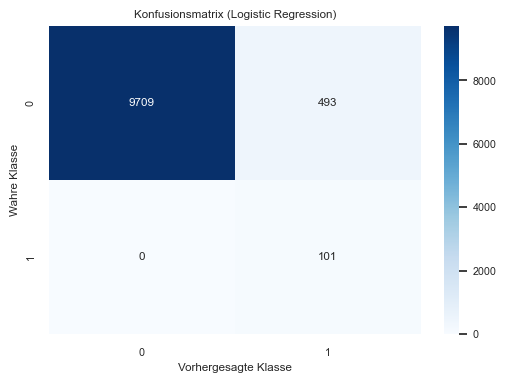

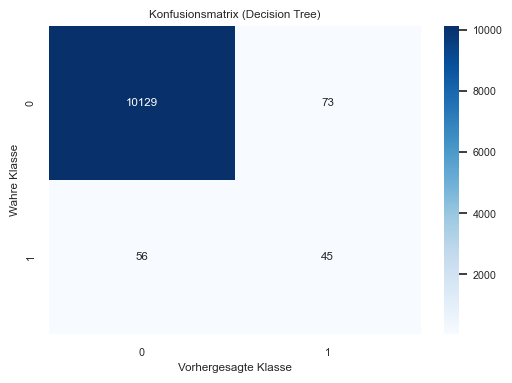

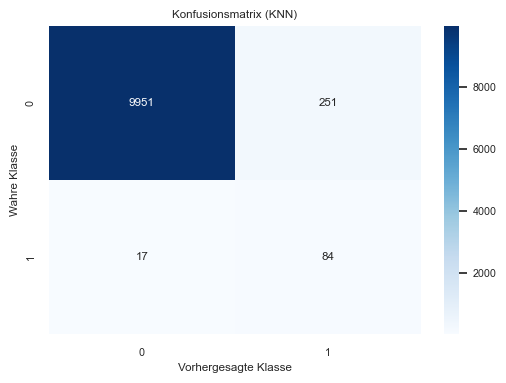

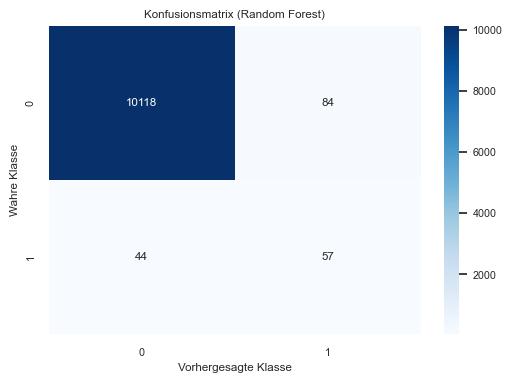

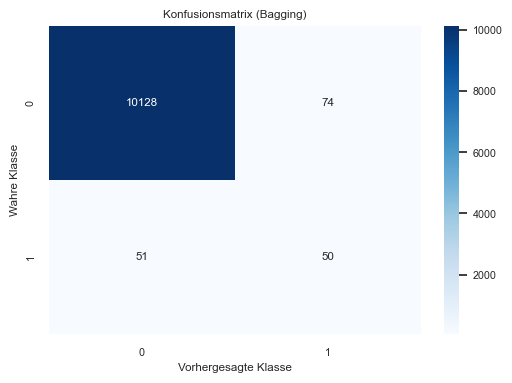

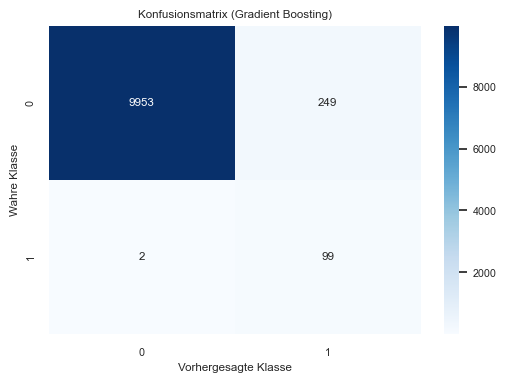

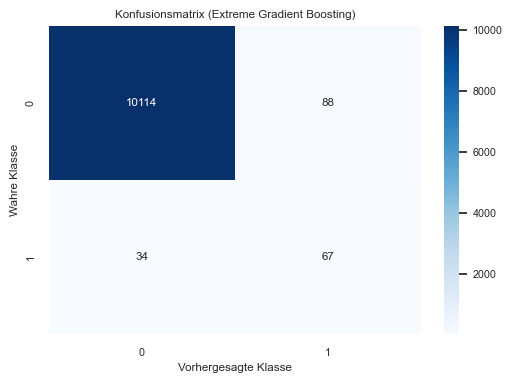

In [737]:
def plot_confusion_matrix(y_pred, title):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Vorhergesagte Klasse')
    plt.ylabel('Wahre Klasse')
    plt.title(f'Konfusionsmatrix ({title})')
    plt.show()

# plotten als Konfusionsmatrizen
plot_confusion_matrix(y_pred_lr, "Logistic Regression")
plot_confusion_matrix(y_pred_dt, "Decision Tree")
plot_confusion_matrix(y_pred_knn, "KNN")
plot_confusion_matrix(y_pred_rf, "Random Forest")
plot_confusion_matrix(y_pred_bag, "Bagging")
plot_confusion_matrix(y_pred_gb, "Gradient Boosting")
plot_confusion_matrix(y_pred_xgb, "Extreme Gradient Boosting")

### Feature Importance

In [738]:
def print_top_10_features(model, feature_names):
    importances = pd.Series(model.feature_importances_, index=feature_names)
    sorted_importances = importances.sort_values(ascending=False).head(10)
    print(sorted_importances)
    return importances

In [739]:
if feature_selection:
    feature_names = selected_features
else:
    feature_names = preprocessor.get_feature_names_out()

# Decision Tree
print("Decision Tree Feature Importances:")
dt_importances = print_top_10_features(dt, feature_names)

# Random Forest
print("Random Forest Feature Importances:")
rf_importances = print_top_10_features(rf, feature_names)

# Gradient Boosting
print("Gradient Boosting Feature Importances:")
gb_importances = print_top_10_features(gb, feature_names)

if hasattr(dt, "feature_importances_"):
    bagging_importances = pd.Series(
        np.mean([tree.feature_importances_ for tree in bagging.estimators_], axis=0),
        index=feature_names
    )
    print("Bagging Feature Importances:")
    print(bagging_importances.sort_values(ascending=False).head(10))
else:
    print("kein feature importances")

# lr_importances = pd.Series(lr.coef_[0], index=feature_names)
# print("Logistic Regression Feature Importances (Koeffizienten):")
# print(lr_importances.abs().sort_values(ascending=False))

print("Extreme Gradient Boosting Feature Importances:")
xgb_importances = print_top_10_features(xgb, feature_names)

Decision Tree Feature Importances:
cat__turbine_id_T006              0.284278
num__tf_wind_speed_mean           0.267270
cat__turbine_type_GE 1.5MW        0.167584
cat__turbine_id_T020              0.111968
cat__turbine_id_T004              0.049960
num__vibration_mm_s               0.026003
cat__ft_season_summer             0.023850
cat__ft_season_spring             0.019412
num__if_temp_pressure             0.009663
num__tf_temperature_difference    0.005610
dtype: float64
Random Forest Feature Importances:
num__tf_wind_speed_mean          0.113030
cat__turbine_id_T020             0.112689
cat__turbine_id_T006             0.093157
cat__turbine_type_GE 1.5MW       0.082185
cat__turbine_id_T004             0.070495
cat__ft_season_summer            0.051890
num__if_temp_pressure            0.037999
cat__ft_season_winter            0.033926
cat__turbine_type_Vestas V90     0.032023
cat__turbine_type_Siemens SWT    0.030587
dtype: float64
Gradient Boosting Feature Importances:
cat__turbin

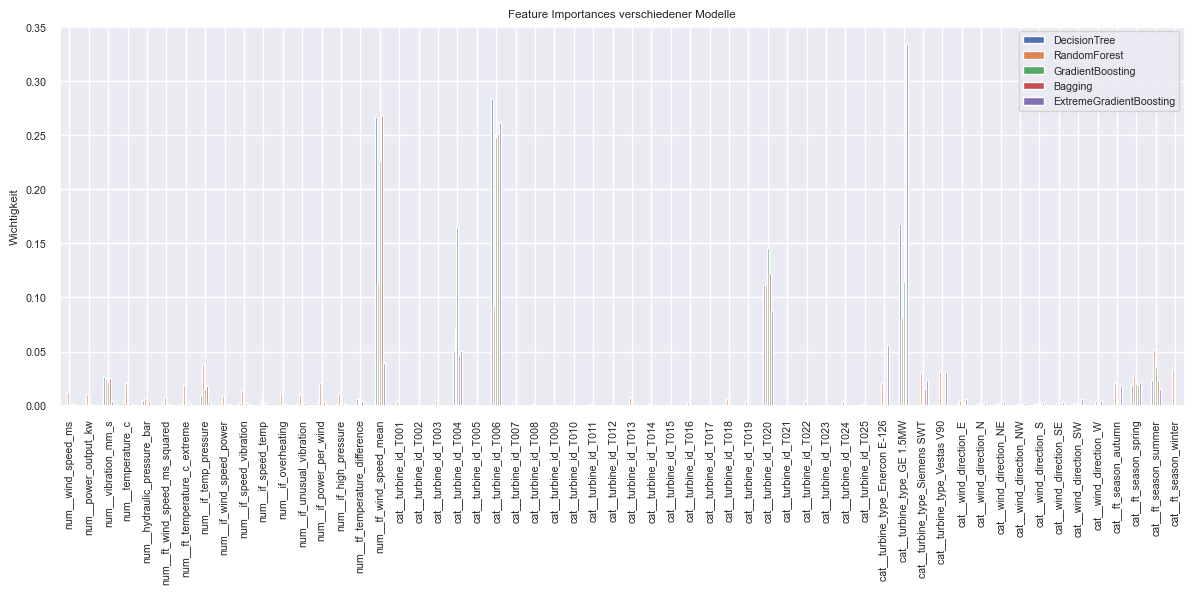

In [740]:
importances_df = pd.DataFrame({
    # 'LogReg': lr_importances.abs(),
    'DecisionTree': dt_importances,
    'RandomForest': rf_importances,
    'GradientBoosting': gb_importances,
    'Bagging': bagging_importances,
    'ExtremeGradientBoosting': xgb_importances
})

importances_df.plot.bar(figsize=(12,6))
plt.title("Feature Importances verschiedener Modelle")
plt.ylabel("Wichtigkeit")
plt.tight_layout()
plt.show()

die wichtigsten Features sind die Turbinen mit ID T004, T006, T020, der Turbinentyp GE 1.5MW, das zeitbasierte Feature des Durchschnitts der Windgeschwindigkeit. Hier sieht man, dass Interaktions-Features nützlich sein können (auch wenn die Ergebnisse trotzdem noch sehr schlecht sind). Dass T004, T006 und T020 so wichtig sind ist nicht verwunderlich, da das die einzigen Turbinen sind, die wirklich Ausfälle in den Daten haben. Weitere wichtige Features pro Modell sind oben aufgelistet.

### Visualisierung des decision trees (just for fun)

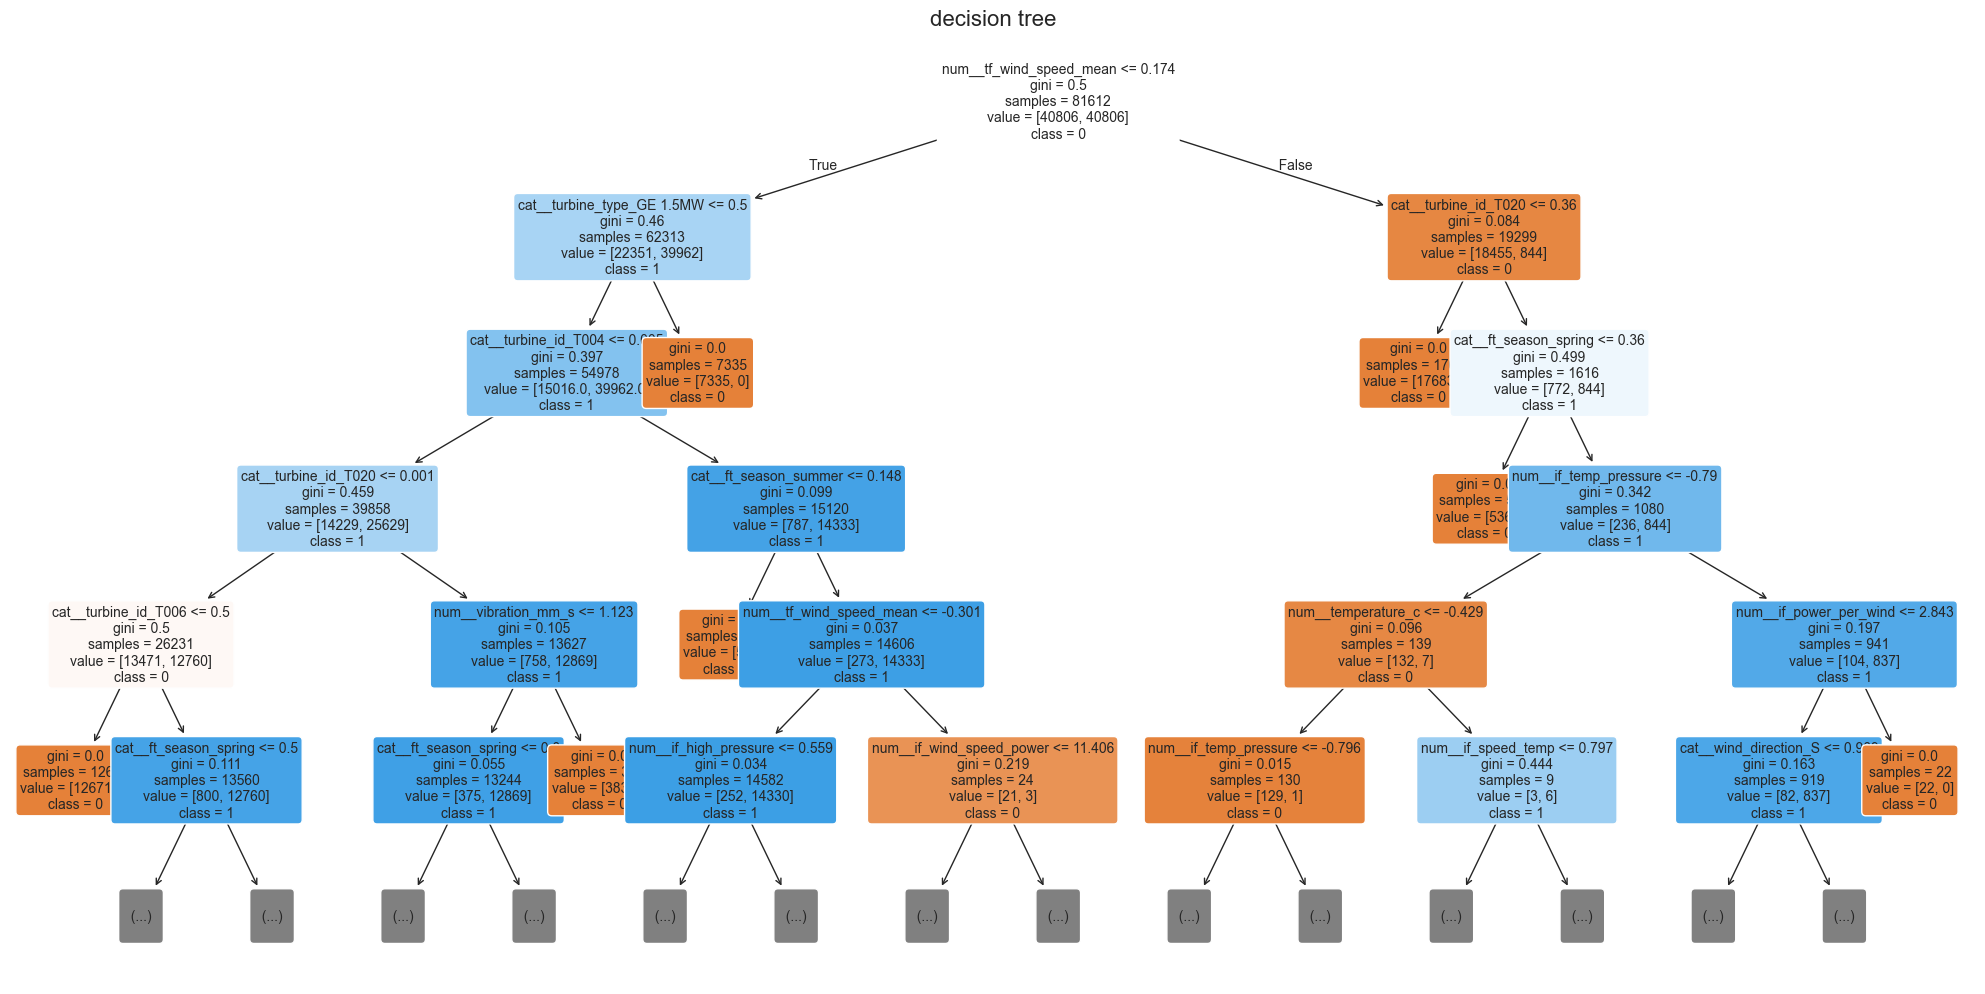

In [741]:
feature_names = preprocessor.get_feature_names_out()
class_names = [str(c) for c in y.unique()]

plt.figure(figsize=(20, 10))
plot_tree(dt, filled=True,
          feature_names=feature_names,
          max_depth=5,
          class_names=class_names,
          rounded=True, fontsize=10)
plt.title("decision tree", fontsize=16)
plt.tight_layout()
plt.show()

## 5. Vergleich und Analyse (deprecated, siehe Abgabe 1)

Durch die unausgeglichenen Klassen ist eine hohe Accuracy unbedeutend, da diese sehr hoch sein kann, wenn nur die Klasse mit den meisten Elementen als TP erkannt wird während die zweite Klasse falsch erkannt wird. Es wurde versucht durch `smote.fit_resample(X_train_processed, y_train)` und `stratify=y` die Klassen besser auszugleichen, was zwar zu etwas besseren, aber keinen guten rgebnissen geführt hat.

Recall ist in einem realen Szenario wichtiger als die Precision, da bei Windturbinen FPs fataler sind als FNs. FNs bedeuten, dass etwas kaputt ist, was aber nicht entdeckt wird. Weniger schlimm ist, dass Windturbinen kontrolliert werden, die gar nicht kaputt sind, auch, wenn das trotzdem den Arbeitsaufwand erhöht und so gut wie möglich vermieden werden sollte.

Da der F1-Score Precision und Recall kombiniert, sollte dieser auch möglichst hoch sein, jedoch ist in der realen Anwendung der Recall vermutlich viel wichtiger.

Den größten Recall haben Logistic Regression und Gradient Boosting. Zudem hat Gradient Boosting einer höhere Präzision und somit einen höheren F1-Score, weshalb sich das am besten für diesen Anwendungsfall eignet. Wenn mehr auf das Gleichgewicht zwischen Recall und Precision geachtet werden sollte, dann sollte Bagging verwendet werden, da hier der beste F1-Score vorliegt. Für alle Ansätze wäre es vermutlich besser, wenn ausgeglichenere Ausgangsdaten präsent wären.

| Modell           | Accuracy | Precision (1) | Recall (1) | F1 (1) | Notiz |
|------------------|----------|---------------|------------|--------|-----------|
| **Logistic Regression** | 0.7365   | 0.03         | 0.89  | 0.06  | mehr FPs als Gradient Boosting |
| **Decision Tree**   | 0.9759   | 0.16         | 0.34      | 0.22  | ausgeglichen, aber allgemein niedrige Werte |
| **KNN**             | 0.9554   | 0.11         | 0.48      | 0.17  | besserer Recall, aber nicht so gut wie LR und GB |
| **Random Forest**   | 0.9807 | 0.16     | 0.24      | 0.19 | ausgeglichen, aber allgemein niedrige Werte |
| **Bagging**         | 0.9794   | 0.20         | 0.37 | 0.26  | Bester F1-Score, aber im Vergleich schlechter Recall, höhere Gefahr |
| **Gradient Boosting**         | 0.8892   | 0.07         | 0.90   | 0.14  | höchster Recall, aber geringe Präzision, viele FPs |

In [742]:


models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'KNN': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

results = {}

for name, model in models.items():
    #! testdaten werden vorher verworfen, wir splitten trainingsdaten nochmal
    scores = cross_val_score(model, X_train_processed, y_train, cv=5, scoring='accuracy')
    results[name] = scores
    print(f"{name}: Mean accuracy = {scores.mean():.3f}, Std = {scores.std():.3f}")

pd.DataFrame(results)

Logistic Regression: Mean accuracy = 0.974, Std = 0.002
KNN: Mean accuracy = 0.985, Std = 0.001
Random Forest: Mean accuracy = 0.995, Std = 0.000
Decision Tree: Mean accuracy = 0.994, Std = 0.001


,Logistic Regression,KNN,Random Forest,Decision Tree
0,0.976414,0.985726,0.995099,0.992158
1,0.973596,0.985358,0.995283,0.995221
2,0.974758,0.986031,0.994731,0.994731
3,0.973962,0.983029,0.994854,0.994915
4,0.971756,0.984867,0.995099,0.994486


In [743]:
best_scores = {name: scores.mean() for name, scores in results.items()}
print(best_scores)

{'Logistic Regression': np.float64(0.9740969242839176), 'KNN': np.float64(0.9850021923324732), 'Random Forest': np.float64(0.9950129839275819), 'Decision Tree': np.float64(0.9943023234925759)}


## Grundlegende Prinzipien von Windturbinen
Basic Infos unter [2]. Stromproduktion effizienter, wenn Windrad höher gebaut: Wind gleichmäßiger und Windgeschwindigkeit höher [2]. Verdopplung der Rotorblattlänge führt zu vervierfachtem Stromverbrauch [2]. Die beste Anzahl der Rotorblätter ist 3 [2]. Offshore-Windturbinen sind größer [2].

Betreiber sollten sich nicht auf die regelmäßige Wartung verlassen, da in einem Fall keine Mängel vor dem Ausfall frestgestellt werden konnten [1]. Demnach sind maintenance-Features unwichtiger.

#### physikalische/technische Zusammenhänge
Bei zu starkem Wind, drehen sie sich weg, dass nichts überlastet wird. Ältere Modelle drehen sich jedoch langsamer [1]. Damit sie nicht "durchdrehen" werden sie in Fahnen- oder Segelstellung gebracht [2]. Können auch abgeschaltet werden [2]. Extrem hohe Windgeschwindigkeiten priorisieren. Hier könnte mit einer mathematischen Funktion hohe Geschwindigkeiten ausschlaggebener gemacht werden (Bspw. s²). Wenn das Feature Windgeschwindigkeit steigt und Power-Output nicht, kann man möglicherweise davon ausgehen, dass es stürmt und die Windturbine gefährdet werden kann. Auch Blitzeinschläge können gefährlich sein [6].

Es gibt Windanlagen mit horizonaler und vertikaler Achse [2].
Neuere Windkraftanlagen schaffen das 30-fache als Anlagen aus dem Jahr 1995 [3].

Temperatur hat Auswirkungen auf Druck [4]. Beide Features sind hier vorhanden. Höhere Temperatur hat niedrigere Luftdichte, wodurch weniger Energie erzeugt wird [4]. Materialeigenschaften können sich bei extremen Temperaturen verändern, was Lebensdauer beeinflusst [4]. Temperatur-Feature hier beachten. Theoretisch könnte man schauen, wie die bestimmten Typen der Windturbinen aufgebaut sind (würde etwas den Rahmen sprengen).

Beispiel: Siemens-Windräder häufig kaputt [5]: Modelle anpassen, dass Siemens Windräder häufiger kaputt sind. -> keine Eindeutigen statistiken, nur Idee.

#### Welche Feature-Kombinationen könnten predictive sein?
- Temperatur und Druck könnten kombiniert werden.
- hohe Windgeschwindigkeit deutet auf Stürme hin, kann gefährlich werden
- wenn sich die Windrichtung zu oft ändert, könnte das auf schlechte Wetterbedingungen hinweisen -> Zeitbasiert
- der Turbinenhersteller könnte entscheidend sein. Es kann recherchiert werden, wann die Turbinen produziert wurden

##### Quellen
- [1] https://wind-turbine.com/magazin/ratgeber/82038/die-groessten-risiken-fuer-windenergieanlagen-teil-2.html
- [2] https://www.enercity.de/magazin/unsere-welt/so-funktioniert-eine-windkraftanlage
- [3] https://orsted.de/gruene-energie/energie-lexikon/windturbine
- [4] https://www.thermal-engineering.org/de/temperaturauswirkungen-auf-die-leistung-von-windturbinen/
- [5] https://de.rt.com/wirtschaft/173457-windraeder-zu-haeufig-defekt-aktien-eingestuerzt/
- [6] https://tkp.at/2024/07/25/windraeder-technisch-mangelhaft-und-gefaehrlich-fuer-mensch-und-tier/ (mies unseriöse Quelle)